In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# from tqdm.auto import tqdm
from tqdm import tqdm
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
student_id=21522188

In [3]:
def initialize_population(num_individuals, num_variables, device="cpu"):
    """
    Khởi tạo quần thể gồm num_individuals cá thể. Mỗi cá thể có num_parameters biến.

    Arguments:
    num_individuals -- Số lượng cá thể
    num_variables -- Số lượng biến

    Returns:
    pop -- Ma trận (num_individuals, num_variables ) chứa quần thể mới được khởi tạo ngẫu nhiên.
    """

    pop = torch.randint(0, 2, (num_individuals, num_variables), device=device)

    return pop


# optimized for multithreading


def crossover_uniform(pop):
    """
    Hàm biến đổi tạo ra các cá thể con.

    Arguments:
    pop -- Quàn thể hiện tại.

    Returns:
    offspring -- Quần thể chứa các cá thể con được sinh ra.
    """
    num_individuals, num_parameters = pop.shape

    # Đảo ngẫu nhiên thứ tự các cá thể trong quần thể
    indexes = torch.randperm(num_individuals, device=pop.device)
    # (num_individuals, num_parameters)
    pop = pop[indexes]

    if num_individuals % 2 != 0:
        pop = pop[:-1]
        num_individuals -= 1

    num_pairs = num_individuals // 2

    # since np.concatenate is slow
    # i.e.
    # pop1      [0, 1, 2, 3,   4, 5, 6, 7]
    # pop2      [4, 5, 6, 7,   0, 1, 2, 3]

    # t         [0, 1, 2, 3,   0, 1, 2, 3]

    # (num_individuals * num_parameters)
    pop1 = pop.reshape(-1)
    pop2 = pop.reshape((2, num_pairs, num_parameters)).flip(0).reshape((-1))

    # (num_individuals * num_parameters)
    t = (
        torch.rand(num_pairs * num_parameters, device=pop.device)
        .unsqueeze(0)
        .expand((2, num_pairs * num_parameters))
        .reshape((-1))
    )

    offsprings = torch.where(t < 0.5, pop1, pop2)

    return offsprings.reshape((num_individuals, num_parameters))


def crossover_SP(pop):
    # single-point crossover

    num_individuals, num_parameters = pop.shape

    # Đảo ngẫu nhiên thứ tự các cá thể trong quần thể
    indexes = torch.randperm(num_individuals, device=pop.device)
    # (num_individuals, num_parameters)
    pop = pop[indexes]

    if num_individuals % 2 != 0:
        pop = pop[:-1]
        num_individuals -= 1

    num_pairs = num_individuals // 2

    # i.e.
    # pop1,pop              [0, 1, 2, 3,   4, 5, 6, 7]
    # pop2                  [4, 5, 6, 7,   0, 1, 2, 3]

    # crossover_indices     [0, 1, 2, 3,   0, 1, 2, 3]

    # (num_individuals, num_parameters)
    # pop1 = pop
    pop2 = (
        pop.reshape((2, num_pairs, num_parameters))
        .flip(0)
        .reshape((num_individuals, num_parameters))
    )

    # crossover_indice for each pair
    crossover_indices = torch.randint(1, num_parameters, (num_pairs,), device=pop.device)
    # repeat for the second part
    crossover_indices = (
        crossover_indices.unsqueeze(0).expand((2, num_pairs)).reshape((-1))
    )

    # https://stackoverflow.com/questions/68400027/set-all-elements-left-to-index-to-one-right-of-index-to-zero-for-list-of-indice
    offsprings = torch.where(
        torch.arange(num_parameters, device=pop.device) < crossover_indices[:, None],
        pop,
        pop2,
    )

    return offsprings

In [4]:
def onemax(pop):
    return torch.sum(pop, dim=-1)


def leadingone(pop):
    first_items = pop[:, 0]
    # indice of the first 0
    first_idx = torch.argmin(pop, dim=-1)
    return torch.where(first_idx == 0, first_items * (pop.shape[1]), first_idx)


def trap(pop, nof_bits=5):
    # assume num_parameters is divisible by nof_bits

    # pop (num_individuals, num_parameters)
    num_individuals, num_parameters = pop.shape

    # (num_individuals, num_parameters//nof_bits )
    t = pop.reshape((num_individuals, -1, nof_bits)).sum(axis=-1)

    # (num_individuals, num_parameters//nof_bits )
    values = torch.where(t < nof_bits, nof_bits - 1 - t, nof_bits)

    # (num_individuals )
    return values.sum(dim=-1)


objective_funcs = {
    "Onemax": onemax,
    "LeadingOne": leadingone,
    "Concatenated Trap-5": trap,
}

In [5]:
def tournament_selection(pop, pop_fitness, selection_size, tournament_size=4):
    # pop (num_individuals, num_parameters)
    num_individuals, num_parameters = pop.shape

    uniform_dis = torch.ones((selection_size, num_individuals), device=pop.device)
    # select tournament_size opponents from the population selection_size times
    # (selection_size * tournament_size)
    t_indices = uniform_dis.multinomial(
        num_samples=tournament_size, replacement=False
    ).flatten()

    # fitness of each opponent
    # (selection_size * tournament_size)
    t_fitness = pop_fitness[t_indices]

    # (selection_size, tournament_size)
    t_fitness = t_fitness.reshape((selection_size, tournament_size))

    # winner of each tournament
    # (selection_size)
    t_winners = torch.argmax(t_fitness, dim=1)

    # convert to the actual indices of t_indices
    t_winners = (
        t_winners + torch.arange(selection_size, device=pop.device) * tournament_size
    )

    return t_indices[t_winners]

In [6]:
def convergence(pop):
    return (pop == pop[0]).all()


def genetic_algorithm_pytorch(
    objective=onemax,
    num_individuals=32,
    num_parameters=100,
    seed=49,
    use_uniform_crossover=True,
    device="cpu"
):
    torch.manual_seed(seed)

    # (P)
    pop = initialize_population(num_individuals, num_parameters, device=device)

    pop_fitness = objective(pop)
    num_evaluations = num_individuals

    # best_fitness = []

    selection_size = num_individuals

    optimal_found = False

    while not convergence(pop):
        # best_fitness.append([num_evaluations, np.max(pop_fitness)])

        # (O)
        offspring = (
            crossover_uniform(pop) if use_uniform_crossover else crossover_SP(pop)
        )

        offspring_fitness = objective(offspring)
        num_evaluations += len(offspring)

        # (P+O)
        pop_off = torch.vstack([pop, offspring])
        pop_off_fitness = torch.concatenate((pop_fitness, offspring_fitness))

        # tournament selection will have a constant tournament_size of 4
        # select N individuals from (P+O) 2N
        # selected_indices is not sorted by fitness
        selected_indices = tournament_selection(
            pop_off, pop_off_fitness, selection_size
        )

        pop = pop_off[selected_indices]
        pop_fitness = pop_off_fitness[selected_indices]

        if (pop_fitness == num_parameters).any():
            optimal_found = True
            break

    # best_fitness.append([num_evaluations, np.max(pop_fitness)])

    return optimal_found, num_evaluations


In [7]:
def genetic_algorithm(
    objective=onemax,
    num_individuals=32,
    num_parameters=100,
    seed=49,
    use_uniform_crossover=True,
    device=None,
):
    if device == None:
        # just use cuda
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # if num_individuals > 64:
        #     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # else:
        #     device = torch.device("cpu")
            
    
    return genetic_algorithm_pytorch(
        objective=objective,
        num_individuals=num_individuals,
        num_parameters=num_parameters,
        seed=seed,
        use_uniform_crossover=use_uniform_crossover,
        device=device
    )

In [8]:
genetic_algorithm()

(False, 608)

# Bisection

In [9]:
def test_multiple(
    objective_func="Onemax",
    n_trials=10,
    num_individuals = 32,
    num_parameters=100,
    init_seed=student_id,
    use_uniform_crossover=True,
    device = None
):
    assert objective_func in objective_funcs.keys()

    success = True
    nums_evaluations = []

    for i in range(n_trials):
        optimal_found, num_evaluations = genetic_algorithm(
            objective=objective_funcs[objective_func],
            num_individuals=num_individuals,
            num_parameters=num_parameters,
            seed=init_seed + i,
            use_uniform_crossover=use_uniform_crossover,
            device=device
        )

        nums_evaluations.append(num_evaluations)

        if not optimal_found:
            success = False
            break
    
    if success:
        return True, nums_evaluations
    
    return False, nums_evaluations

In [10]:
def find_upper_bound(
    objective_func="Onemax",
    n_trials=10,
    num_parameters=100,
    init_seed=student_id,
    use_uniform_crossover=True,
    upper_bound_limit=2**13,
    device = None
):
    assert objective_func in objective_funcs.keys()

    upper_bound = 4

    nums_evaluations = []

    while True:
        success, nums_evaluations = test_multiple(
            objective_func=objective_func,
            n_trials=n_trials,
            num_individuals=upper_bound,
            num_parameters=num_parameters,
            init_seed=init_seed,
            use_uniform_crossover=use_uniform_crossover,
            device=device
        )

        if success:
            break

        upper_bound *= 2

        if upper_bound > upper_bound_limit:
            return False, upper_bound, nums_evaluations

    # success, upper_bound
    return True , upper_bound, nums_evaluations

In [11]:
%time find_upper_bound(num_parameters=10)

CPU times: user 53.5 ms, sys: 203 µs, total: 53.7 ms
Wall time: 52.8 ms


(True, 32, [128, 160, 160, 96, 64, 192, 128, 160, 128, 160])

In [12]:
def find_MRPS(
    objective_func="Onemax",
    n_trials=10,
    num_parameters=100,
    init_seed=student_id,
    use_uniform_crossover=True,
    upper_bound_limit=2**13,
    device = None
):
    assert objective_func in objective_funcs.keys()

    success, upper_bound, nums_evaluations = find_upper_bound(
        objective_func=objective_func,
        n_trials=n_trials,
        num_parameters=num_parameters,
        init_seed=init_seed,
        use_uniform_crossover=use_uniform_crossover,
        upper_bound_limit=upper_bound_limit,
        device = device
    )

    if not success:
        return None, None

    lower_bound = upper_bound // 2

    while (upper_bound - lower_bound) / float(upper_bound) > 0.1:
        mid = int((upper_bound + lower_bound) // 2)

        success, n_evals = test_multiple(
            objective_func=objective_func,
            n_trials=n_trials,
            num_individuals=mid,
            num_parameters=num_parameters,
            init_seed=init_seed,
            use_uniform_crossover=use_uniform_crossover,
            device = device
        )

        if success:
            upper_bound = mid
            nums_evaluations = n_evals
        else:
            lower_bound = mid

        if (upper_bound - lower_bound) <= 2:
            break

    # avg_evals = np.average(nums_evaluations) if len(nums_evaluations) != 0 else 0
    avg_evals = np.average(nums_evaluations)

    return upper_bound, avg_evals

In [13]:
%time find_MRPS(num_parameters=300)

CPU times: user 763 ms, sys: 0 ns, total: 763 ms
Wall time: 762 ms


(352, 12531.2)

In [14]:
def bisection(
    objective_func="Onemax",
    n_trials=10,
    num_parameters=100,
    init_seed=student_id,
    use_uniform_crossover=True,
    upper_bound_limit=2**13,
    device = None
):
    MRPS = []
    avgs_evals = []

    # 10 Bisections
    for i in tqdm(range(10)):
        upper, avg = find_MRPS(
            objective_func=objective_func,
            n_trials=n_trials,
            num_parameters=num_parameters,
            init_seed=init_seed + i*10,
            use_uniform_crossover=use_uniform_crossover,
            upper_bound_limit=upper_bound_limit,
            device = device
        )
        if upper is None:
            return [], []
        
        MRPS.append(upper)
        avgs_evals.append(avg)
    return MRPS, avgs_evals

In [15]:
l = [10, 20, 40, 80, 160]  # problem size

res = {}

for k in ["Onemax", "trap", "LeadingOnes"]:
    res[k] = {
        "uniform": {"MRPS": [], "avgs_evals": []},
        "SP": {"MRPS": [], "avgs_evals": []},
    }

# Onemax
uniform_crossover

In [16]:
%%time

for i in l:
    print(f"Problem size: {i}")
    MRPS, avgs_evals = bisection(
        objective_func="Onemax",
        n_trials=10,
        num_parameters=i,
        init_seed=student_id,
        use_uniform_crossover=True,
        upper_bound_limit=2**13,
        device=None
    )
    if len(MRPS) == 0:
        print(f"8192 population_size exceeded")
        break
    res["Onemax"]["uniform"]["MRPS"].append(MRPS)
    res["Onemax"]["uniform"]["avgs_evals"].append(
        avgs_evals
    )

Problem size: 10


100%|██████████| 10/10 [00:00<00:00, 11.00it/s]


Problem size: 20


100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


Problem size: 40


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


Problem size: 80


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


Problem size: 160


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

CPU times: user 14.6 s, sys: 33.6 ms, total: 14.6 s
Wall time: 14.6 s


In [17]:
np.save("results.npy", res)

In [18]:
%%time

for i in l:
    print(f"Problem size: {i}")
    MRPS, avgs_evals = bisection(
        objective_func="Onemax",
        n_trials=10,
        num_parameters=i,
        init_seed=student_id,
        use_uniform_crossover=False,
        upper_bound_limit=2**13,
        device=None
    )
    if len(MRPS) == 0:
        print(f"8192 population_size exceeded")
        break
    res["Onemax"]["SP"]["MRPS"].append(MRPS)
    res["Onemax"]["SP"]["avgs_evals"].append(
        avgs_evals
    )

Problem size: 10


100%|██████████| 10/10 [00:01<00:00,  9.97it/s]


Problem size: 20


100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


Problem size: 40


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Problem size: 80


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Problem size: 160


100%|██████████| 10/10 [00:41<00:00,  4.11s/it]

CPU times: user 53.4 s, sys: 47.5 ms, total: 53.4 s
Wall time: 53.4 s


In [19]:
np.save("results.npy", res)


# Trap k=5
uniform_crossover

In [20]:
%%time

for i in l:
    print(f"Problem size: {i}")
    MRPS, avgs_evals = bisection(
        objective_func="Concatenated Trap-5",
        n_trials=10,
        num_parameters=i,
        init_seed=student_id,
        use_uniform_crossover=True,
        upper_bound_limit=2**13,
        device=None
    )
    if len(MRPS) == 0:
        print(f"8192 population_size exceeded")
        break
    res["trap"]["uniform"]["MRPS"].append(MRPS)
    res["trap"]["uniform"]["avgs_evals"].append(
        avgs_evals
    )

Problem size: 10


100%|██████████| 10/10 [00:01<00:00,  9.19it/s]


Problem size: 20


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Problem size: 40


  0%|          | 0/10 [00:00<?, ?it/s]

8192 population_size exceeded
CPU times: user 18.6 s, sys: 23.9 ms, total: 18.7 s
Wall time: 18.7 s


In [21]:
np.save("results.npy", res)

In [22]:
%%time

for i in l:
    print(f"Problem size: {i}")
    MRPS, avgs_evals = bisection(
        objective_func="Concatenated Trap-5",
        n_trials=10,
        num_parameters=i,
        init_seed=student_id,
        use_uniform_crossover=False,
        upper_bound_limit=2**13,
        device=None
    )
    if len(MRPS) == 0:
        print(f"8192 population_size exceeded")
        break
    res["trap"]["SP"]["MRPS"].append(MRPS)
    res["trap"]["SP"]["avgs_evals"].append(
        avgs_evals
    )

Problem size: 10


100%|██████████| 10/10 [00:00<00:00, 11.29it/s]


Problem size: 20


100%|██████████| 10/10 [00:01<00:00,  5.19it/s]


Problem size: 40


100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Problem size: 80


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


Problem size: 160


  0%|          | 0/10 [00:00<?, ?it/s]

8192 population_size exceeded
CPU times: user 35.5 s, sys: 19.9 ms, total: 35.5 s
Wall time: 35.5 s


In [23]:
np.save("results.npy", res)


# LeadingOnes
uniform_crossover

In [24]:
%%time

for i in l:
    print(f"Problem size: {i}")
    MRPS, avgs_evals = bisection(
        objective_func="LeadingOne",
        n_trials=10,
        num_parameters=i,
        init_seed=student_id,
        use_uniform_crossover=True,
        upper_bound_limit=2**13,
        device=None
    )
    if len(MRPS) == 0:
        print(f"8192 population_size exceeded")
        break
    res["LeadingOnes"]["uniform"]["MRPS"].append(MRPS)
    res["LeadingOnes"]["uniform"]["avgs_evals"].append(
        avgs_evals
    )

Problem size: 10


100%|██████████| 10/10 [00:01<00:00,  5.23it/s]


Problem size: 20


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Problem size: 40


100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


Problem size: 80


100%|██████████| 10/10 [04:49<00:00, 28.93s/it]


Problem size: 160


  0%|          | 0/10 [08:21<?, ?it/s]

8192 population_size exceeded
CPU times: user 13min 55s, sys: 340 ms, total: 13min 55s
Wall time: 13min 55s


In [25]:
np.save("results.npy", res)

In [26]:
%%time

for i in l:
    print(f"Problem size: {i}")
    MRPS, avgs_evals = bisection(
        objective_func="LeadingOne",
        n_trials=10,
        num_parameters=i,
        init_seed=student_id,
        use_uniform_crossover=False,
        upper_bound_limit=2**13,
        device=None
    )
    if len(MRPS) == 0:
        print(f"8192 population_size exceeded")
        break
    res["LeadingOnes"]["SP"]["MRPS"].append(MRPS)
    res["LeadingOnes"]["SP"]["avgs_evals"].append(
        avgs_evals
    )

Problem size: 10


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Problem size: 20


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Problem size: 40


 30%|███       | 3/10 [02:46<06:28, 55.45s/it]

8192 population_size exceeded
CPU times: user 3min 5s, sys: 56 ms, total: 3min 6s
Wall time: 3min 6s


In [27]:
np.save("results.npy", res)


In [28]:
res = np.load("results.npy", allow_pickle=True).tolist()

In [29]:
def plot_res(uniform_res, SP_res, ylabel="", axes=None):
    if len(uniform_res) == 0 or len(SP_res) == 0:
        return
    l = [10, 20, 40, 80, 160]

    mean_uniform_res = np.mean(uniform_res, axis=-1)
    std_uniform_res = np.std(uniform_res, axis=-1)

    mean_SP_res = np.mean(SP_res, axis=-1)
    std_SP_res = np.std(SP_res, axis=-1)

    axes.errorbar(l[:len(mean_uniform_res)], mean_uniform_res, yerr=std_uniform_res, color="r", fmt="-0", label="uniform crossover")
    axes.errorbar(l[:len(mean_SP_res)], mean_SP_res, yerr=std_SP_res, fmt="-0",color="b", label="single-point crossover")

    axes.set_yscale("log", base=10)
    axes.set_xscale("log", base=2)
    axes.set_xlabel("Problem Size")
    axes.set_ylabel(ylabel)

    length = max(len(mean_uniform_res), len(mean_SP_res))
    axes.set_xticks(ticks = l[:length], labels = [str(s) for s in l[:length]])
    axes.legend()


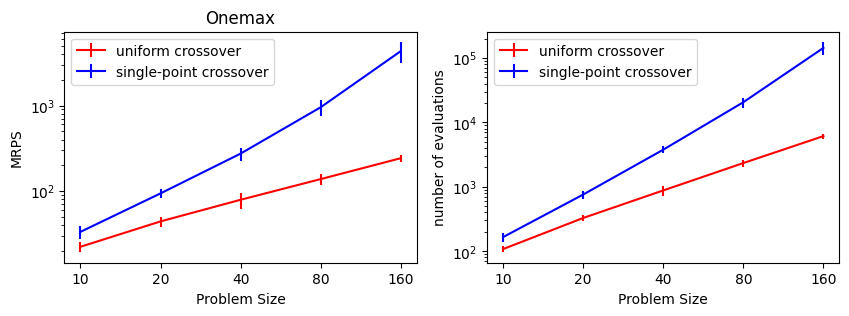

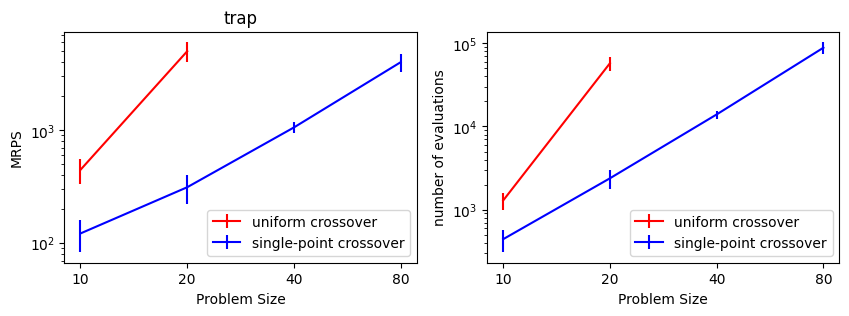

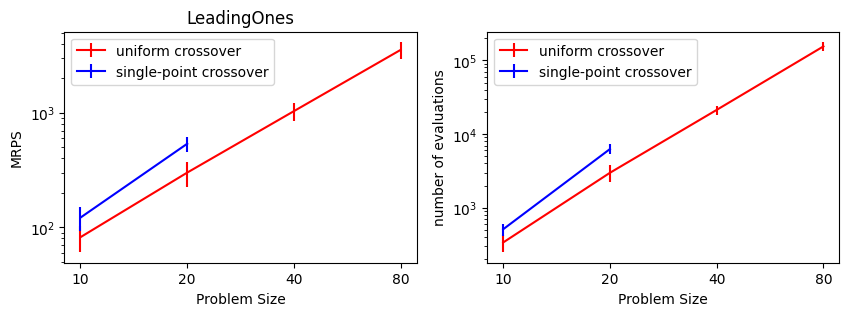

In [30]:
for t in res.keys():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    ax[0].set_title(t)
    plot_res(
        res[t]["uniform"]["MRPS"],
        res[t]["SP"]["MRPS"],
        "MRPS",
        ax[0]
    )
    plot_res(
        res[t]["uniform"]["avgs_evals"],
        res[t]["SP"]["avgs_evals"],
        "number of evaluations",
        ax[1]
    )
    plt.show()
